# EXPERIENCE DE LA BILLE SUR GLISSIÈRE

In [1]:
import urllib
import os
from notebook import notebookapp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

import io
import base64
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, Label, VBox
from IPython.display import HTML, Video, IFrame

from bokeh.plotting import figure, curdoc
from bokeh.models.widgets import Slider, CheckboxButtonGroup, PreText
from bokeh.layouts import row, column, widgetbox
from bokeh.models import ColumnDataSource, Slider, Button, TextInput, Arrow, OpenHead, NormalHead, VeeHead
from bokeh.plotting import figure, show, ColumnDataSource

from bokeh.io import output_notebook, show, export_png

output_notebook()


Loading BokehJS ...

## Le problème :

Une bille est lâchée dans une glissière qui forme un looping. Si elle n'est pas lâchée d'une hauteur suffisante, elle ne complète pas le looping. De quelle hauteur faut-il la lâcher pour qu'elle complète le looping ?

## Importer les vidéos et données

Trois vidéos montrent l'expérience; on peut choisir entre trois hauteurs initiales de lâcher de la bille

In [2]:
# Input
height_label = Label('Choisir une hauteur initiale:')
height_input = widgets.Dropdown(options=['h1', 'h3', 'h5'], value=None, 
disabled=False,)

# Output
text_output = widgets.Output()
video_output = widgets.Output()
with video_output: print("La vidéo s'affichera ici.")

def height_event_handler(change):
     # Récuperer le nom de la vidéo choisie
    h = change.new

     # Effacer les outputs
    text_output.clear_output()
    video_output.clear_output()

     # Importer des données de la video
    df_vid = pd.read_csv('data_bille/'+h+'-data.csv', index_col=0)
    df_vid = df_vid.rename({'VideoAnalysis: X (cm)': 'x', 
'VideoAnalysis: Y (cm)':'y', 'VideoAnalysis: X Velocity (cm/s)':'v_x', 
'VideoAnalysis: Y Velocity (cm/s)':'v_y'},
                            axis='columns')

     # Calculer hauteur initiale
    y_min_vid = df_vid['y'].min()
    h_init = df_vid['y'].iloc[0] - y_min_vid

    R = 11.62

     # Afficher la hauteur initiale
    with text_output:
        print('Hauteur initiale choisie: {} = {:0.2f}[cm].{:0.2f}R'.format(h,h_init, h_init/R))

     # Afficher la vidéo
    with video_output:
        display(Video('data_bille/{}-dots.mov'.format(h)))

# Observer les changements sur le choix de la hauteur
height_input.observe(height_event_handler, names='value')
# Afficher le tout
display(VBox([height_label, height_input, text_output, video_output]));

## Détail des calculs et de la modélisation

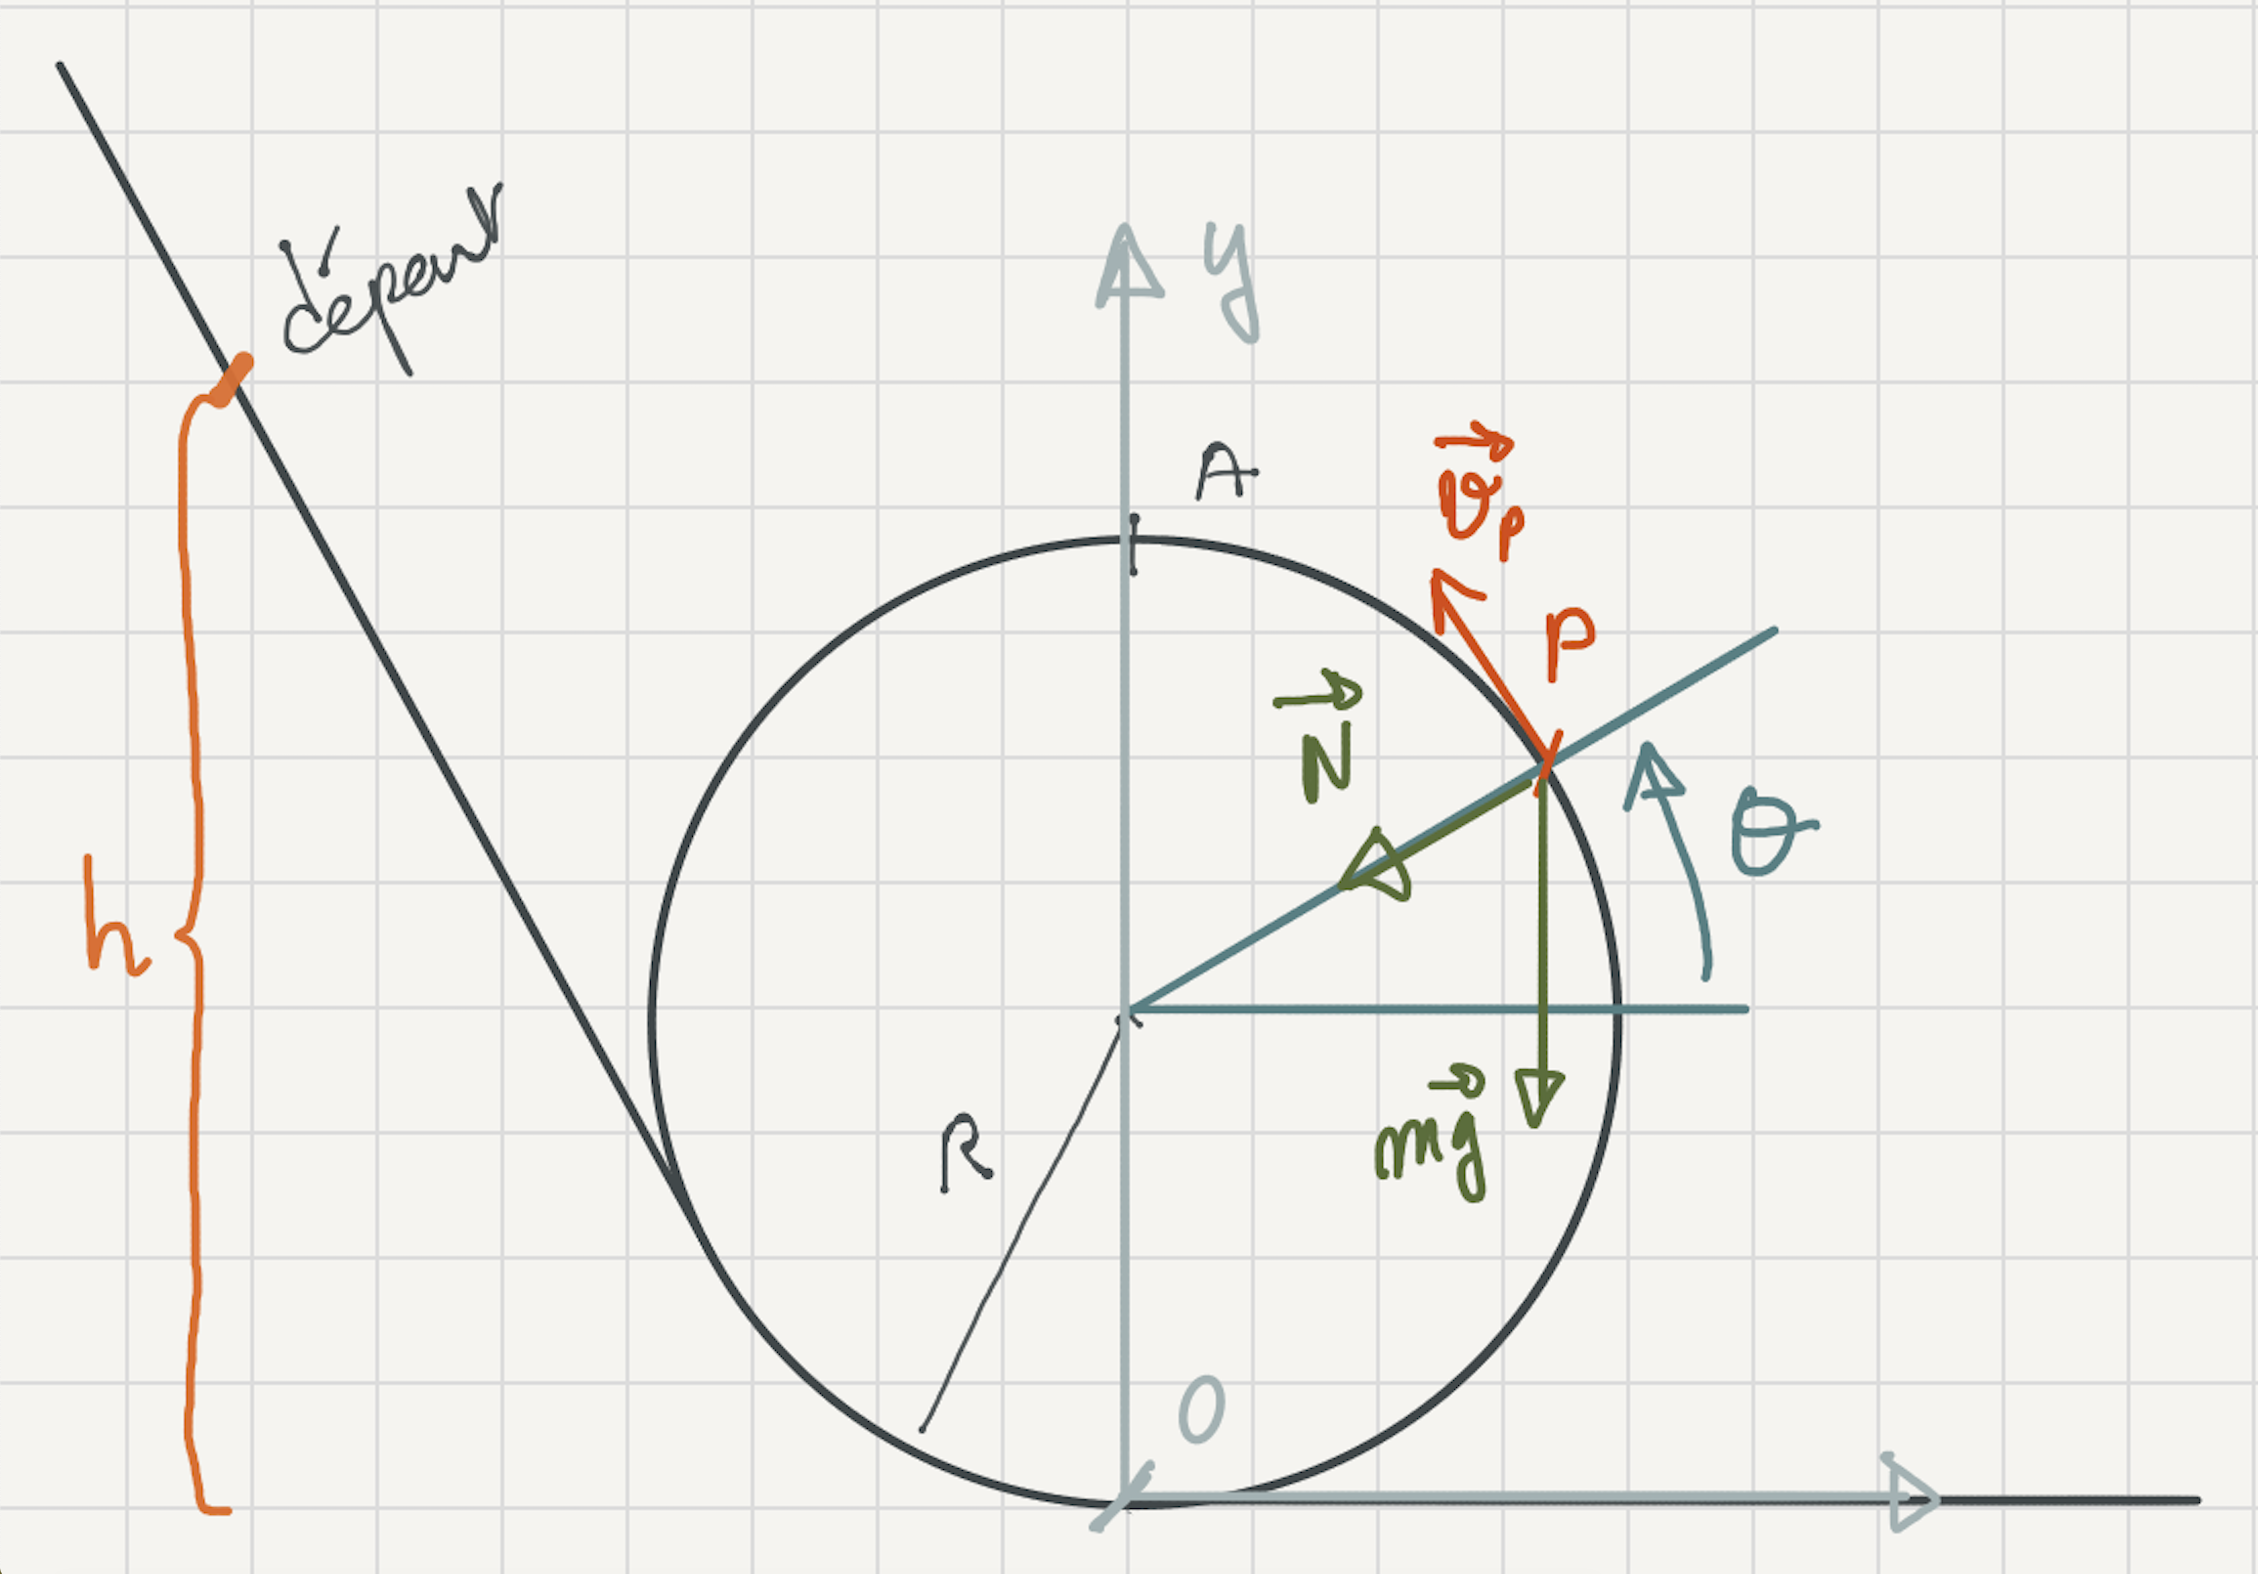

In [3]:
from IPython.display import Image
Image("Glissiere.png")

On lâche la bille d'une hauteur h et on observe son comportement au point P en supposant qu'elle suit jusqu'en P la trajectoire imposée par la glissière. On prend $P$ dans le quart supérieur droit de la glissière ($\theta >0$)

### 1. On cherche la norme de $\vec v$ au point P: $v_p$

La conservation de l'énergie donne: 
$$mgh = mgy_{p} + \frac{1}{2}mv_{p}^{2}$$

$$y_p = R ( 1 + \sin\theta)$$

$$v_p = \sqrt{2g[h - R ( 1 + \sin\theta)]}$$

Un calcul plus juste tient compte de l'énergie de rotation de la bille. Dans ce cas la conservation de l'énergie devient: 
$$mgh = mgy_p + \frac{1}{2}mv_{p}^{2} + \frac{1}{2}Iw_{p}^{2}$$

$$I = \frac{2}{5}mr^2$$

$$w_p = \frac{v_p}{r}$$  avec r le rayon de la bille 

$$mgh = mgy_p + \frac{1}{2}mv_{p}^{2} + \frac{1}{2}\frac{2}{5}mr^2\frac{v_p^2}{r^2}$$

$$gh = gR(1 + \sin\theta) + \frac{7}{10}v_p^2$$

$$v_p = \sqrt{\frac{10}{7}g[h - R(1 + \sin\theta)]}$$

de manière générale, on peut donc écrire

$$v_p = \sqrt{A g[h - R(1 + \sin\theta)]}$$

Avec $A$ un facteur qui vaut 2 pour un objet qui glisse et $\frac{10}{7}$ pour une sphère homogène qui roule sans glisser.


### 2. On cherche les composantes du vecteur $\vec v_p$

La direction du vecteur vitesse en P s'obtient par le fait qu'il est tangent à la glissière

$$\vec v=\begin{pmatrix}-v_p\sin\theta\\v_p\cos\theta \end{pmatrix}$$

### 3. On calcule la trajectoire parabolique qu'aurait une bille libre dans le champ de pesanteur si elle était lancée en P avec $\vec v_p$.

$$\vec r_P=\begin{pmatrix}-v_p\sin\theta \, t + R \cos \theta \\-\frac{1}{2} g t^2 + v_p\cos\theta \, t 
+ R (1+\sin \theta)
\end{pmatrix}$$

### 4. Analyse des forces exercées sur la bille en P.

Les forces sont le poids $\vec P$ et la réaction de la glissière $\vec N$

$$ \vec P = m \vec g = - mg \vec e_y $$ 

$$ \vec N = N \vec n$$ 
avec $\vec n$ vecteur normal au support pointant vers le centre du cercle. 

$\vec N$ est forcément dirigée vers le centre du cercle donc $N \geq 0$. 

$N <0$ impliquerait que la glissière attire la bille. 

Au point P, 
$$ \sum \vec F = m \vec a = m \frac{v_p^2}{R}\vec n + m \left ( \frac{\mathrm{d} v}{\mathrm{d} t} \right )\vec \tau = -mg\vec e_y + N\vec n$$

Projeté sur $\vec n $, on obtient, 

$$m g \sin \theta  + N = m \frac{v_P^2}{R}$$

$$N= m(\frac{v_P^2}{R} - g \sin \theta)$$

$$N= m g \Big(A \frac{h}{R} - A (1 + \sin\theta) -  \sin \theta \Big)$$

On remarque donc que si $h$ n'est pas assez grand, $N$ va devenir négatif pour un $\theta < \frac{\pi}{2}$. Cela signifie que au point P, la bille devrait être attiré par la glissière pour rester dessus... elle décolle. 

## Tracé de la figure 

### Paramètres pour la figure

In [4]:
# Définition de l' image de fond
import base64

def file2src(filename, data_type='image/png'):
    with open(filename, "rb") as image_file:
        data = base64.b64encode(image_file.read())
    image_file.close()
    return 'data:{};base64,{}'.format(data_type, data.decode())

# Définition de l'image de fond
img_path = file2src("data_bille/background.png")

# Import des données du video
df = pd.read_csv('data_bille/data-05-04-19.csv', index_col=0)
df = df.rename({'VideoAnalysis: X (cm)': 'x', 'VideoAnalysis: Y (cm)':'y',
       'VideoAnalysis: X Velocity (cm/s)':'v_x', 'VideoAnalysis: Y Velocity (cm/s)':'v_y'}, axis='columns')

# Calculer les limites  
y_min = df['y'].min()
x_min = df['x'].min()
x_max = df['x'].max()
x_lowest = df.loc[df['y'] == y_min]['x'].iloc[0]

# Calculer le rayon de la boucle
df_h = df.loc[df['x'] < 20]
df_h = df_h.loc[df_h['x'] > -20]
R = df_h['y'].max() - df_h['y'].min()
idx = df_h.loc[df_h['y'] == df_h['y'].min()]
R = R/2

### Équations et paramètres initiaux

In [5]:
# Choissir A: 2 ou 10/7
A = 10/7

# Définir parametres initiaux
g = 9.81 # pesanteur
h = 2*R # diamètre
theta = 20 # angle par rapport à l'horizontale
to_rad = lambda x: np.pi*x/180.0
thetarad = to_rad(theta)

t = np.linspace(0, 2, 100) #  temps après  que la bille  est  arrivéee en P (tracé parabole)
neg_t = np.linspace(0, -1, 100) #  temps avant que la bille soit arrivéee en P (tracé parabole)

# Eq. parametrique de la parabole
x_p = lambda v, ang, t: -v*np.sin(ang)*t + R*np.cos(ang)
y_p = lambda v, ang, t: -0.5*g*t*t + v*np.cos(ang)*t + R*(1 + np.sin(ang))

# Définition du vecteur vitesse (tracé depuis P)
vx = lambda v, ang: np.linspace(x_p(v, ang, t)[0], x_p(v, ang, t)[0] - 0.5*v*np.sin(ang), 10) 
vy = lambda v, ang: np.linspace(y_p(v, ang, t)[0], y_p(v, ang, t)[0] + 0.5*v*np.cos(ang), 10) 

# Define equations
vitesse_p = lambda h, A, theta_rad: math.sqrt(A*g*R*(h - (1 + np.sin(theta_rad)))) #Vitesse au point A
normale_p = lambda hsurR, A, angle: g*(A*hsurR-A*(1+np.sin(angle))-np.sin(angle)) #Force normale au point A


### Figure

In [6]:
## PLOT

def modify_doc(doc):
    
    # Définir information à visualiser
    x = -df['x']
    y = df['y'] - y_min
    x0 = x.iloc[0]
    y0 = y.iloc[0]

    # Définir glissière
    slope2 = (y.iloc[6] - y.iloc[5]) / (x.iloc[6] - x.iloc[5])
    get_x = lambda y_ini: x0 - (y0 - y_ini)*(1/slope2)

    line_ini_y = np.linspace(2, y.iloc[0], 20)
    line_ini_x = get_x(line_ini_y)

    slope = np.arctan((y.iloc[6] - y.iloc[5]) / (x.iloc[6] - x.iloc[5]))
    line_end_x = x.iloc[-1] - np.linspace(0, 40, 20)*np.cos(-slope-0.02)
    line_end_y = y.iloc[-1] - np.linspace(0, 40, 20)*np.sin(-slope -0.02)

    angle = np.linspace(0, 2*np.pi, 100)
    
    # Conditions initiales 
    g = 9.81
    h = 2.0
    A = 10/7
    theta = 45
    thetarad = to_rad(theta)
    t = np.linspace(0, 2, 100)
    neg_t = np.linspace(0, -1, 100)
    vit_P = vitesse_p(h,A, thetarad)
    lwidth = 2.5 


    def initialize(h_init, thetarad):
        # Calculer position, vitesse et forces au point P
        vit_P = vitesse_p(h_init, A, thetarad) # vitesse en P
        n_P = normale_p(h_init, A, thetarad) # force normale en P
        
        # coordonnées parabole après point P
        x_parab = x_p(vit_P, thetarad, t) 
        y_parab = y_p(vit_P, thetarad, t)
        
        # coordonnées parabole avant point P
        x_parab_neg = x_p(vit_P, thetarad, neg_t)
        y_parab_neg = y_p(vit_P, thetarad, neg_t)
        
        # vecteur force normale
        norm_end_x = x_parab[0] - n_P*np.cos(thetarad)
        norm_end_y =  y_parab[0] - n_P*np.sin(thetarad)
        
        # vecteur vitesse
        v_x, v_y = vx(vit_P, thetarad), vy(vit_P, thetarad)
        
        P = {
            'x_init': [get_x(h_init*R)], 'y_init':[h_init*R],
            'x_point_P': [x_parab[0]], 'y_point_P': [y_parab[0]]
        }
        
        CURV = {
            'x_point_P_parab_pos': x_parab, 'y_point_P_parab_pos': y_parab,
            'x_point_P_parab_neg': x_parab_neg, 'y_point_P_parab_neg': y_parab_neg
        }
        
        ANG = {
            'l_hor_x':np.linspace(0,R, 100), 'l_hor_y':[R]*100, 
            'l_ver_x': np.linspace(0, x_parab[0], 100), 'l_ver_y': np.linspace(R,y_parab[0],100)
            
        }
        
        FORCES = {
            'grav_x': [x_parab[0]]*10, 'grav_y': np.linspace(y_parab[0], -9.8+y_parab[0], 10),
            'arrow_up_grav_x': np.linspace(x_parab[0], 0.5 + x_parab[0], 10), 
            'arrow_up_grav_y': np.linspace(-9.8 + y_parab[0], 0.6 -9.8 + y_parab[0], 10),
            'arrow_down_grav_x': np.linspace(x_parab[0], -0.5 + x_parab[0], 10), 
            'arrow_down_grav_y': np.linspace(-9.8 + y_parab[0], 0.6 -9.8 + y_parab[0], 10),
            'norm_x': np.linspace(x_parab[0], norm_end_x, 10), 'norm_y': np.linspace(y_parab[0], norm_end_y, 10),
            'arrow_up_norm_x':  norm_end_x  + np.linspace(0, 0.1*n_P*np.cos(thetarad - np.pi*20/180), 10), 
            'arrow_up_norm_y':  norm_end_y  + np.linspace(0, 0.1*n_P*np.sin(thetarad - np.pi*20/180), 10), 
            'arrow_down_norm_x': norm_end_x + np.linspace(0, 0.1*n_P*np.cos(thetarad + np.pi*20/180), 10), 
            'arrow_down_norm_y': norm_end_y +  np.linspace(0, 0.1*n_P*np.sin(thetarad + np.pi*20/180), 10)
        }
              
        VEL = {
            'v_x': v_x,
            'v_y': v_y, 
            'arrow_up_vel_x': v_x[-1] + np.linspace(0, 0.1*vit_P*np.cos(thetarad - np.pi*70/180), 10),
            'arrow_up_vel_y': v_y[-1] + np.linspace(0, 0.1*vit_P*np.sin(thetarad - np.pi*70/180), 10), 
            'arrow_down_vel_x': v_x[-1] + np.linspace(0,- 0.1*vit_P*np.cos(thetarad + np.pi*70/180), 10),
            'arrow_down_vel_y': v_y[-1] + np.linspace(0,- 0.1*vit_P*np.sin(thetarad + np.pi*70/180), 10) 

        }
    
        return P, CURV, ANG, FORCES, VEL
    
  
    # Calculer les valeurs initiales
    P, C, ANG, FORCES, VEL = initialize(h, thetarad)

    # Créer dictionnaire pour acceder aux données
    source_P = ColumnDataSource(data = P)
    source_C = ColumnDataSource(data = C)
    source_ANGLE = ColumnDataSource(data = ANG)
    source_FORCES = ColumnDataSource(data = FORCES)
    source_VITESSE = ColumnDataSource(data= VEL)
    
    
    # Figure
    p = figure(title="Trajectory", plot_height=425, plot_width=950, x_range=(-57,53), y_range=(-5,45),\
               background_fill_color='#ffffff')
    
    # Définir image de fond
    p.image_url(url=[img_path], x=-56.5, y=45, w=110, h=45, alpha=0.2, angle=-np.pi*1/180)


    # Partie fixe de la figure:
    # Glissière
    p.line(line_ini_x, line_ini_y, color='#635c74', alpha=0.7, line_width=2.5, legend='Piste')
    p.line(R*np.sin(angle), R + R*np.cos(angle), color='#635c74', alpha=0.6, line_width=2.5, legend='Piste')
    # Centre de la boucle
    p.circle(0,R,size=3, fill_color='#635c74', line_color='#635c74', legend='Centre')


    # Variables:
    # Point initial
    p_ini = p.circle('x_init', 'y_init', source=source_P, size=6, fill_color='#e32020', line_color='#e32020', legend='Point Initial')

    # Point A
    p_a = p.circle('x_point_P','y_point_P', source=source_P, size=6, \
                   legend='A', line_color='#e32020', fill_color='#e32020')

    # Parabole
    parab = p.line('x_point_P_parab_pos', 'y_point_P_parab_pos', source=source_C, color='#e32020', line_width=1.5, alpha=0.8, \
                   legend='Parabole')

    parab_neg = p.line('x_point_P_parab_neg', 'y_point_P_parab_neg', source=source_C, color='#e32020', line_width=1.5, alpha=0.8, \
                   legend='Parabole')
    

    # Angle theta
    l_h = p.line('l_hor_x', 'l_hor_y', source=source_ANGLE, line_width=lwidth, color='#000000', alpha=0.2)
    l_v = p.line('l_ver_x', 'l_ver_y', source=source_ANGLE, line_width=lwidth ,color='#000000', alpha=0.2)

    # Force gravité
    f_g = p.line('grav_x', 'grav_y', source=source_FORCES, line_width=lwidth, color='#178717', alpha=0.8, legend='mg')
    a_u_f = p.line('arrow_up_grav_x', 'arrow_up_grav_y', source=source_FORCES, line_width=lwidth, color='#178717', alpha=0.8, legend='mg')
    a_d_f = p.line('arrow_down_grav_x', 'arrow_down_grav_y', source=source_FORCES, line_width=lwidth, color='#178717', alpha=0.8, legend='mg')

    # Force normale
    f_n = p.line('norm_x', 'norm_y', source=source_FORCES, line_width=lwidth*1.2, color='#064d06', alpha=0.8, legend='N')
    a_u_n = p.line('arrow_up_norm_x', 'arrow_up_norm_y', source=source_FORCES, line_width=lwidth, color='#064d06', alpha=0.8, legend='N')

    a_d_n = p.line('arrow_down_norm_x', 'arrow_down_norm_y', source=source_FORCES, line_width=lwidth, color='#064d06', alpha=0.8, legend='N')

    # Vitesse
    v = p.line('v_x', 'v_y', source=source_VITESSE, color='#01B9FF', legend='Vitesse', line_width=lwidth) 
    a_u = p.line('arrow_up_vel_x','arrow_up_vel_y', source=source_VITESSE, line_width=lwidth)
    a_d = p.line('arrow_down_vel_x','arrow_down_vel_y', source=source_VITESSE, line_width=lwidth)
    
    
    # Définir sliders 
    slider_h = Slider(start=2, end=3, step=0.05, value=2, title='Hauteur initiale')
    slider_om = Slider(start=0, end=90, step=1, value=45, title='Theta')
    
    pre = PreText(text='Point initiale.\tx:{:3.2f} \ty:{:3.2f} \nPoint A.\tx: {:3.2f} \ty: {:3.2f} \nVitesse.\t{:3.2f}[cm/s]\tx:{:3.2f}[cm/s]\ty:{:3.2f}[cm/s] \nForce normale. \t{:3.2f} [N]'\
                  .format(source_P.data['x_init'][0], source_P.data['y_init'][0],source_P.data['x_point_P'][0], source_P.data['y_point_P'][0], \
                         vit_P, -vit_P*np.cos(thetarad), vit_P*np.sin(thetarad), normale_p(h, A, thetarad)),
    width=500, height=100)
    
    
    def refresh_source(attrname, old, new):
        
        # Mettre à jour les valeurs à afficher 
        om = slider_om.value
        h = slider_h.value
        #h = h*R # hauteur par rapport au rayon
        omrad = to_rad(om)

        P, C, ANG, FORCES, VEL = initialize(h, omrad)
        
        source_P.data = P
        source_C.data = C
        source_ANGLE.data = ANG

        source_FORCES.data = FORCES
        source_VITESSE.data = VEL
        
        vit_P = vitesse_p(h, A, omrad)
        x_p = source_C.data['x_point_P_parab_pos'][0]
        y_p = source_C.data['y_point_P_parab_pos'][0]
        
        pre.text='Point initiale.\tx:{:3.2f} \ty:{:3.2f} \nPoint A.\tx: {:3.2f} \ty: {:3.2f} \nVitesse.\t{:3.2f}[cm/s]\tx:{:3.2f}[cm/s]\ty:{:3.2f}[cm/s] \nForce normale. \t{:3.2f} [N]'\
                  .format(source_P.data['x_init'][0], source_P.data['y_init'][0],source_P.data['x_point_P'][0], source_P.data['y_point_P'][0], \
                         vit_P, -vit_P*np.sin(omrad), vit_P*np.cos(omrad), normale_p(h, A, omrad))
        
        
    slider_h.on_change('value', refresh_source)
    slider_om.on_change('value', refresh_source)
    
    layout = column(
        row(p),
        row(slider_h, slider_om),
        row(pre)
    )

    
    doc.add_root(layout)
    

In [7]:
def remote_jupyter_proxy_url(port):
    """
    Callable to configure Bokeh's show method when a proxy must be
    configured.

    If port is None we're asking about the URL
    for the origin header.
    """
    
    base_url = os.environ['EXTERNAL_URL']
    host = urllib.parse.urlparse(base_url).netloc

    # If port is None we're asking for the URL origin
    # so return the public hostname.
    if port is None:
        return host

    service_url_path = os.environ['JUPYTERHUB_SERVICE_PREFIX']
    proxy_url_path = 'proxy/%d' % port

    user_url = urllib.parse.urljoin(base_url, service_url_path)
    full_url = urllib.parse.urljoin(user_url, proxy_url_path)
    return full_url



def show_document(doc):
    servers = list(notebookapp.list_running_servers())[0]
    if servers['hostname'] == 'localhost':
        show(doc) 
    else:
        show(doc, notebook_url=remote_jupyter_proxy_url)


### Utilisation de la figure

On varie h et $\theta$ et on observe: 

- l'intensité et la direction de $\vec N$, calculé par la relation $N= m g \Big(A \frac{h}{R} - A (1 + \sin\theta) -  \sin \theta \Big)$

- et l'allure de la parabole qu'aurait une bille en chute libre avec $\vec v_p$ en P. 

***Comment se place la parabole par rapport à la glissière quand N=0 ? Et quand N>0 ? Et N<0 ?***

In [8]:
show_document(modify_doc) 

# Feedback

In [ ]:
IFrame('https://www.surveymonkey.com/r/NOTOSURVEY?notebook_set=MecaDRIL&notebook_id=bille_sur_glissiere', 600, 800)